In [151]:
%matplotlib inline
from __future__ import division
import matplotlib.pyplot as plt
import pandas as pds
import scipy
import seaborn as sns
import numpy as np
import random
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn import metrics
from scipy import stats
from sklearn.neighbors import NearestNeighbors
from sklearn.tree import DecisionTreeClassifier
from pandas.plotting import parallel_coordinates
import graphviz 
from sklearn import tree
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn import neighbors
from sklearn.metrics import balanced_accuracy_score

#np.random.seed(10)
#random.seed(10)

In [3]:
df_global = pds.read_csv('./Data_Classif/Data.txt', sep="\t") # load a pandas dataframe from csv

Les données comportent des champs inutiles à notre étude, et des valeurs manquantes qu'il faut trier.

## Nettoyage des lignes

Suppression des time codes.

In [4]:
df_global=df_global.drop(["Time","Time Code","Country Code"],axis=1)

Supression des lignes contenant des valeurs manquantes

In [5]:
filtered_df = df_global.dropna()
filtered_df.head()

,Country Name,Children out of school,CO2,NR electricity,Life expectancy,Population,Urban population,Area,GDP,Compulsory education,Labor force,Agricultural land
1,Albania,5.63382,1.749211,0.000000,77.70200,2895092.0,55.387,27400.0,4413.081697,9.0,53.652000,43.332117
7,Argentina,0.64461,4.462904,64.000402,76.08900,42539925.0,91.249,2736690.0,12976.636425,13.0,60.403000,54.518049
10,Australia,2.50737,16.083474,86.735892,82.14878,23145901.0,85.502,7682300.0,67990.290030,10.0,65.008003,51.627156
12,Azerbaijan,6.32932,3.785069,93.041877,71.65600,9416801.0,54.145,82659.0,7875.756953,10.0,64.546997,57.704545
14,Bahrain,6.26169,23.804357,100.000000,76.48200,1315411.0,88.835,770.0,24737.171783,9.0,71.518997,11.168831


In [6]:
filtered_df.head()

,Country Name,Children out of school,CO2,NR electricity,Life expectancy,Population,Urban population,Area,GDP,Compulsory education,Labor force,Agricultural land
1,Albania,5.63382,1.749211,0.000000,77.70200,2895092.0,55.387,27400.0,4413.081697,9.0,53.652000,43.332117
7,Argentina,0.64461,4.462904,64.000402,76.08900,42539925.0,91.249,2736690.0,12976.636425,13.0,60.403000,54.518049
10,Australia,2.50737,16.083474,86.735892,82.14878,23145901.0,85.502,7682300.0,67990.290030,10.0,65.008003,51.627156
12,Azerbaijan,6.32932,3.785069,93.041877,71.65600,9416801.0,54.145,82659.0,7875.756953,10.0,64.546997,57.704545
14,Bahrain,6.26169,23.804357,100.000000,76.48200,1315411.0,88.835,770.0,24737.171783,9.0,71.518997,11.168831


Les données retenues pour l'étude sont :
* Country name : nom du pays.
* Children out of school : proportion des enfants non scolarisés parmi ceux d'âge inférieur à l'âge de scolarisaton de premier et second degré (%).
* CO2 : émissions de CO2 (tonnes/habitant).
* NR electricity : proportion d'électricité issue de sources non renouvelables et émettrices de CO2 (essence, gaz et charbon) parmi la production totale (%).
* Life expectancy : espérance de vie moyenne à la naissance (années).
* Population : population totale.
* Urban population : proportion d'urbains dans la population totale (%).
* Area : aire terrsetre du pays (km^2).
* GDP : PIB par habitant d'âge moyen (en Dollars US actuels).
* Compulsory education : durée légale minimale d'enseignement obligatoire (années).
* Labor force : proportion de personnes âgées de 15 ans et plus économiquement actives dans la population (%).
* Agricultural land : proportion du territoire utilisé pour l'agrigulture (%).



## Normalisation des données

### Centrage

On centre les données car elles sont exprimées dans des variables différentes et ont des ordres de grandeur complètement différents.

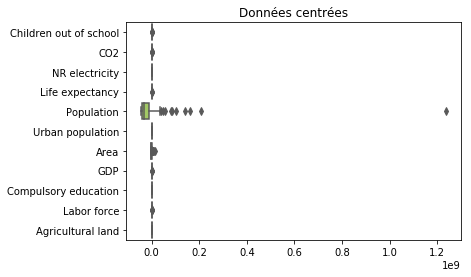

In [7]:
ax=sns.boxplot(data=(filtered_df.drop("Country Name",axis=1) - filtered_df.drop("Country Name",axis=1).mean()),
               orient="h", palette="Set2")
_=ax.set_title(u"Données centrées")

Nous devons également réduire en raison de la variance élevée de la population.

### Réduction 

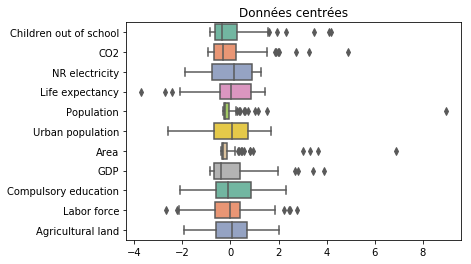

In [8]:
ax=sns.boxplot(data=((filtered_df.drop("Country Name",axis=1) - filtered_df.drop("Country Name",axis=1).mean())
                     /filtered_df.drop("Country Name",axis=1).std()), orient="h", palette="Set2")
_=ax.set_title(u"Données centrées")

In [9]:
dfo=(filtered_df.drop("Country Name",axis=1) - filtered_df.drop("Country Name",axis=1).mean())/filtered_df.drop("Country Name",axis=1).std()
dfoc=dfo.copy()
dfoc["Country"]=filtered_df["Country Name"]

# Recherche des outliers

Comme précédemment nous allons chercher les outliers grâce à DBSCAN. La première étape sera donc de paramétriser ce modèle en traçant la distance pour chaque point à son 4e voisin plus proche grâce à l'algorithme des KNN.

### Définition des paramètres de DBSCAN grâce à KNN

In [10]:
nbrs = NearestNeighbors(n_neighbors=4, algorithm='ball_tree').fit(dfo)
distances, indices = nbrs.kneighbors(dfo)
distances_to_4 = distances[:,3]
distances_to_4 = sorted(distances_to_4 , reverse = False)

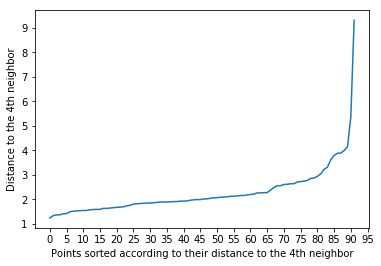

In [11]:
Index = range(0,len(distances_to_4))
plt.plot(Index , distances_to_4)
plt.xlabel('Points sorted according to their distance to the 4th neighbor')
t=plt.ylabel('Distance to the 4th neighbor')
_=plt.xticks(np.arange(0, 100, step=5))

D'après le graphique ci-dessus on observe un coude pour les pays d'indices entre 80 et 90.

In [12]:
mean_dist_knee = sum(distances_to_4[80:90])/10
mean_dist_knee

3.576514777149344

On considérera donc un rayon de recherche d'environs 3.576, et un nombre minimum de point égal à 10, pour considérer un cluster.

### Analyse des résultats de DBSCAN

In [18]:
outliers_det = DBSCAN(min_samples=10,eps=mean_dist_knee).fit(dfo)
print "Nombre d'outliers :",sum(outliers_det.labels_ == -1)

Nombre d'outliers : 6


In [19]:
dfol= dfo.copy(deep=True) # Copy of DF_kmeans1
dfol['Labels'] = outliers_det.labels_

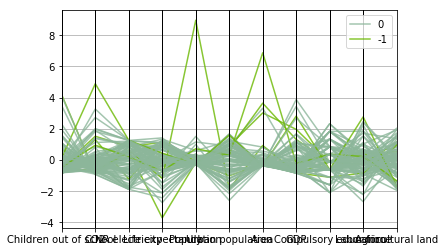

In [20]:
parallel_coordinates(dfol,'Labels', alpha=0.8)
plt.show()

In [21]:
print(dfoc["Country"][dfol['Labels'] == -1])

10              Australia
35                 Canada
47          Cote d'Ivoire
89                  India
159                 Qatar
161    Russian Federation
Name: Country, dtype: object


Les pays ci-dessus sont les outliers.

In [23]:
dff=dfol[dfol.Labels != -1]
dff=dff.drop('Labels',axis=1)
dff["Country"]=dfoc["Country"][dfol['Labels'] != -1]
dff.head()

,Children out of school,CO2,NR electricity,Life expectancy,Population,Urban population,Area,GDP,Compulsory education,Labor force,Agricultural land,Country
1,0.055405,-0.696201,-1.876930,0.432529,-0.291573,-0.652658,-0.370542,-0.696435,-0.612305,-0.862056,0.131700,Albania
7,-0.764361,-0.275301,0.134525,0.172820,-0.004043,1.213444,0.829788,-0.337704,1.347071,-0.108451,0.671874,Argentina
12,0.169681,-0.380435,1.047264,-0.540938,-0.244274,-0.717287,-0.346060,-0.551382,-0.122461,0.354138,0.825752,Azerbaijan
14,0.158569,2.724599,1.265949,0.236097,-0.303030,1.087830,-0.382340,0.154949,-0.612305,1.132413,-1.421480,Bahrain
17,0.246590,0.077362,1.236223,-0.409758,-0.243917,0.430308,-0.292783,-0.547063,-0.612305,0.282584,0.115869,Belarus


Ce sont les données finales sur lesquelles on va travailler.

# Labels de classe par discrétisation

Dans la suite de notre étude nous allons étudier nos données à l'aide d'une étiquette de classe, triant les pays en fonction de leur PIB par habitant.

On discrétise le PIB par habitant à l'aide d'un Kmeans. Pour avoir une idée du nombre de classes, on trace l'histogramme sur les données réduites.

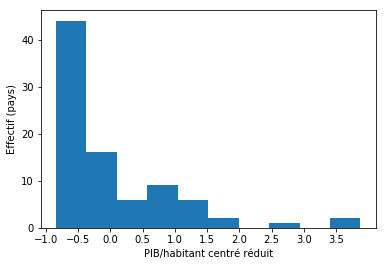

In [24]:
h=plt.hist(dff["GDP"])
plt.xlabel(u"PIB/habitant centré réduit")
plt.ylabel("Effectif (pays)")
_=plt.xticks(np.arange(-1,4,.5))

On distingue 3 classes (<0.25 / 0.25-2.2 / >2.0).

In [25]:
def kmeans_1D(attribute,n):
    """Prend en entrée un nparray et n clusters"""
    km1 = KMeans(n_clusters=n) # create a KMeans object
    km1.fit(attribute.reshape(-1,1))
    return km1

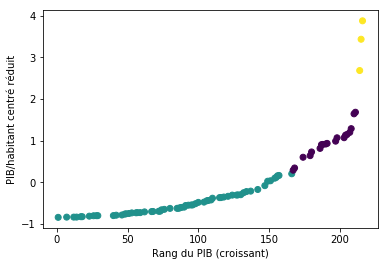

In [26]:
V_GDP  = np.array(sorted(dff['GDP']))
km_gdp = kmeans_1D(V_GDP,3)
plt.scatter(dff.index,sorted(dff['GDP']),c=km_gdp.labels_.astype(np.float))
plt.ylabel(u"PIB/habitant centré réduit")
_=plt.xlabel("Rang du PIB (croissant)")

In [27]:
dff.sort_values(by =['GDP'] , ascending = False).iloc[:3,-1]

116     Luxembourg
147         Norway
188    Switzerland
Name: Country, dtype: object

On observe 3 pays très riches par rapport aux autres groupes (le Danemark, la Norvèg et la Suisse). Les limites de classes de kmeans sont proches de celles trouvées graphiquement par l'histogramme.

On compte le nombre de labels de chaque classe.

In [28]:
unique, counts = np.unique(km_gdp.labels_, return_counts=True)
print counts
c=counts[1]-1
b=counts[1]+counts[0]-1
print(V_GDP[b],V_GDP[c])

[19 64  3]
(1.6820208216541859, 0.20324183820304462)


On associe un label à chaque PIB.
On considèrera 3 groupes :
* Les pays pauvres (C)
* Les pays riches (B)
* Les pays très riches (A)

On transforme la colonne correspondante.

In [29]:
def discretize_GDP(counts,df,vect,c,b):
    """Fonction pour discrétiser le PIB dans un dataframe à partir des effectifs de classe de K-means counts.
        Attention, le PIB doit être en colonne 7.
        Attention, il faut vérifier dans quel ordre sont les clusters.
        Retourne un dataframe discrétisé dfd."""
    # Bornes des classes
    dfd=df.copy()
    i=0
    for i in range(len(df)):
        # column 7 = GDP
        if df.iloc[i,7]<=vect[c]:
            dfd.iloc[i,7]="C"
        elif df.iloc[i,7]<=vect[b] and dff.iloc[i,7]>vect[c]:
            dfd.iloc[i,7]="B"
        elif dff.iloc[i,7]>vect[b]:
            dfd.iloc[i,7]="A"
    return dfd

In [30]:
dfd=discretize_GDP(counts,dff,V_GDP,c,b)
dfd.head()

,Children out of school,CO2,NR electricity,Life expectancy,Population,Urban population,Area,GDP,Compulsory education,Labor force,Agricultural land,Country
1,0.055405,-0.696201,-1.876930,0.432529,-0.291573,-0.652658,-0.370542,C,-0.612305,-0.862056,0.131700,Albania
7,-0.764361,-0.275301,0.134525,0.172820,-0.004043,1.213444,0.829788,C,1.347071,-0.108451,0.671874,Argentina
12,0.169681,-0.380435,1.047264,-0.540938,-0.244274,-0.717287,-0.346060,C,-0.122461,0.354138,0.825752,Azerbaijan
14,0.158569,2.724599,1.265949,0.236097,-0.303030,1.087830,-0.382340,C,-0.612305,1.132413,-1.421480,Bahrain
17,0.246590,0.077362,1.236223,-0.409758,-0.243917,0.430308,-0.292783,C,-0.612305,0.282584,0.115869,Belarus


On a un dafaframe avec les PIB discrétisés.

## Préparation des données pour la classification

In [31]:
dffea = dfd.drop(['GDP','Country'],axis=1)
classes = dfd["GDP"]
sortedLabelList = sorted(list(set(classes)))

## Arbre de décision

### Jeu d'entraiement

In [113]:
tX_train, tX_test, ty_train, ty_test = train_test_split(dffea, classes, test_size=0.2, random_state=5)

In [90]:
treeModel = DecisionTreeClassifier(criterion = 'entropy', random_state=10, min_samples_leaf=10)
t=treeModel.fit(tX_train, ty_train)

In [91]:
tM=metrics.confusion_matrix(y_true=ty_train, y_pred=ty_train, labels=sortedLabelList)
print(tM)

[[ 2  0  0]
 [ 0 15  0]
 [ 0  0 51]]


In [92]:
trueLabels=['A','B','C']
predictLabels=['a','b','c']
allLabels=trueLabels+predictLabels

In [93]:
dot_data = tree.export_graphviz(t, out_file=None, 
                         feature_names=dffea.columns,  
                         class_names=sortedLabelList, # needs to be lexicographically sorted
                         filled=True, rounded=True,  
                         special_characters=True) 
graph = graphviz.Source(dot_data)
graph

ExecutableNotFound: failed to execute ['dot', '-Tsvg'], make sure the Graphviz executables are on your systems' PATH

### Jeu test

In [94]:
ty_predict = treeModel.predict(tX_test)
print "Accurracy classique :",metrics.accuracy_score(ty_test, ty_predict)
print u"Accurracy pondérée :",balanced_accuracy_score(ty_test, ty_predict)

Accurracy classique : 0.9444444444444444
Accurracy pondérée : 0.6666666666666666


On choisit pour cette étude d'utiliser l'accuracy pondérée car les classes ont des effectifs très différents.

Comme on peut le voir, les deu métriques ne donnent pas les mêmes conclusions : en effet, l'accurracy classique sous-estime le coût d'une mauvaise classification dans la classe de PIB A (très petite), alors que l'accurracy pondérée prend en compte la taille de la classe cible.

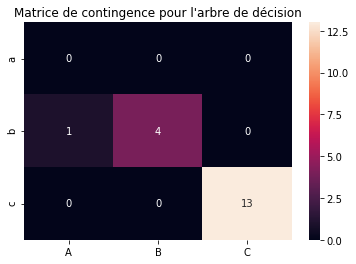

In [95]:
tMP=metrics.confusion_matrix(y_true=ty_test, y_pred=ty_predict, labels=sortedLabelList)
tmdfp = pds.DataFrame(data=tMP, copy=True, index=trueLabels, columns=predictLabels)
tmdfp = tmdfp.transpose()
ax=sns.heatmap(tmdfp, annot=True)
_=ax.set_title(u"Matrice de contingence pour l'arbre de décision")

Matrice de contingence. Verticalement et en minuscule, les classes prédites. Horizontalement et en majuscules, les classes réelles.

In [96]:
print metrics.classification_report(ty_test, ty_predict)

              precision    recall  f1-score   support

           A       0.00      0.00      0.00         1
           B       0.80      1.00      0.89         4
           C       1.00      1.00      1.00        13

   micro avg       0.94      0.94      0.94        18
   macro avg       0.60      0.67      0.63        18
weighted avg       0.90      0.94      0.92        18



/Users/lisa/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/lisa/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/lisa/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


On remarque que la classe A est mal prédite (d'ailleurs, on a un warning car l'effectif est trop faible pour obtenir des mesures pertinentes pour cette classe). C'est dû au petit effectif des pays riches. En effet, le modèle de test avait seulement un seul vrai A...

Ici, le problème est qu'on a des classes d'effectif très hétérogènes. Pour remédier à cela, il faudrait peut-être en faire des outliers, ou inclure des outliers exclus auparavant qui augmenteraient l'effectif de la classe A.

## K-NN

In [120]:
kX_train, kX_test, ky_train, ky_test = train_test_split(dffea, classes, test_size=0.2, random_state=15)

knnModel = neighbors.KNeighborsClassifier(n_neighbors=5, weights='uniform', p=2)
knnModel.fit(kX_train, ky_train)
kM=metrics.confusion_matrix(y_true=ky_train, y_pred=ky_train, labels=sortedLabelList)
print(kM)

 [[ 2  0  0]
 [ 0 17  0]
 [ 0  0 49]]


In [121]:
ky_predict = knnModel.predict(kX_test)
print "Accurracy classique :",metrics.accuracy_score(ky_test, ky_predict)
print u"Accurracy pondérée :",balanced_accuracy_score(ky_test, ky_predict)

Accurracy classique : 0.8888888888888888
Accurracy pondérée : 0.6444444444444445


De même que pour l'arbre de décision, on remarque le coût élevé d'une petite classe sur l'accurracy pondérée.

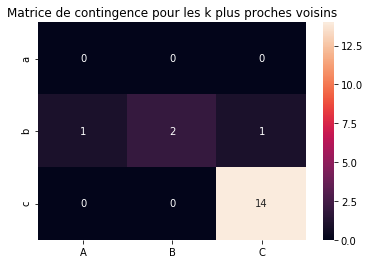

In [104]:
kMP=metrics.confusion_matrix(y_true=ky_test, y_pred=ky_predict, labels=sortedLabelList)
kmdfp = pds.DataFrame(data=kMP, copy=True, index=trueLabels, columns=predictLabels)
kmdfp = kmdfp.transpose()
ax=sns.heatmap(kmdfp, annot=True)
_=ax.set_title(u"Matrice de contingence pour les k plus proches voisins")

Matrice de contingence. Verticalement et en minuscule, les classes prédites. Horizontalement et en majuscules, les classes réelles.

In [105]:
print metrics.classification_report(ky_test, ky_predict)

              precision    recall  f1-score   support

           A       0.00      0.00      0.00         1
           B       0.50      1.00      0.67         2
           C       1.00      0.93      0.97        15

   micro avg       0.89      0.89      0.89        18
   macro avg       0.50      0.64      0.54        18
weighted avg       0.89      0.89      0.88        18



/Users/lisa/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/lisa/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/lisa/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


On retrouve le même problème qu'avec l'arbre de classification.

## Détection de sur-apprentissage

In [106]:
def plotErrorTest(step,dffeatures,classes,model,start=.1,stop=.9):
    prop=np.arange(start,stop,step)
    error=np.ndarray(len(prop))
    i=0
    for p in prop:
        j=0
        rep=100
        errmoy=np.ndarray(rep)
        for k in range(rep):
            X_train, X_test, y_train, y_test = train_test_split(dffeatures, classes, test_size=p)
            #train
            model.fit(X_train, y_train)
            # test
            y_predict = model.predict(X_test)
            errmoy[j]=(y_predict != y_test).mean()
            j+=1
        error_rate = np.mean(errmoy)*100
        error[i]=error_rate
        i+=1
    plt.plot(prop,error)
    plt.xlabel("Proportion du jeu test")
    plt.ylabel(u"Taux d'erreur (%)")
    plt.title(type(model))

In [107]:
def plotErrorLeaf(dffeatures,classes,start=1,stop=50):
    leaf=np.arange(start,stop)
    error=np.ndarray(len(leaf))
    i=0
    for l in leaf:
        j=0
        rep=100
        errmoy=np.ndarray(rep)
        for k in range(rep):
            model = DecisionTreeClassifier(criterion = 'entropy', random_state=10, min_samples_leaf=l)
            X_train, X_test, y_train, y_test = train_test_split(dffeatures, classes, test_size=.2)
            #train
            model.fit(X_train, y_train)
            # test
            y_predict = model.predict(X_test)
            errmoy[j]=(y_predict != y_test).mean()
            j+=1
        error_rate = np.mean(errmoy)*100
        error[i]=error_rate
        i+=1
    plt.plot(leaf,error)
    plt.xlabel("Nombre minimal d'objets dans un noeud")
    plt.ylabel(u"Taux d'erreur (%)")
    plt.title(type(model))

In [108]:
def plotErrorNeighbors(dffeatures,classes,start=1,stop=50):
    neighb=np.arange(start,stop)
    error=np.ndarray(len(neighb))
    i=0
    for n in neighb:
        j=0
        rep=100
        errmoy=np.ndarray(rep)
        for k in range(rep):
            model = neighbors.KNeighborsClassifier(n_neighbors=n, weights='uniform', p=2)
            X_train, X_test, y_train, y_test = train_test_split(dffeatures, classes, test_size=.2)
            #train
            model.fit(X_train, y_train)
            # test
            y_predict = model.predict(X_test)
            errmoy[j]=(y_predict != y_test).mean()
            j+=1
        error_rate = np.mean(errmoy)*100
        error[i]=error_rate
        i+=1
    plt.plot(neighb,error)
    plt.xlabel("Nombrede voisins")
    plt.ylabel(u"Taux d'erreur (%)")
    plt.title(type(model))

### Erreur en fonction de la proportion du jeu test

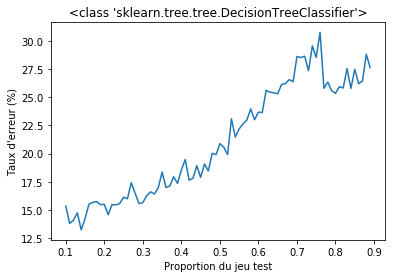

In [57]:
plotErrorTest(.01,dffea,classes,treeModel)

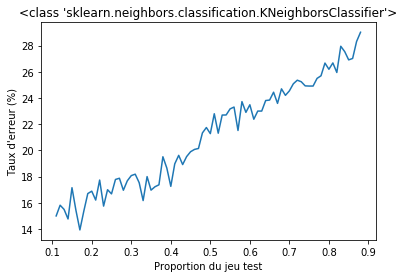

In [524]:
plotErrorTest(.01,dffea,classes,knnModel,.11,.89)

On ne détecte pas de surapprentissage. Par contre, à partir de 80 % et 40 % de test respectivement pour l'arbre de décision et pour les k plus proches voisins, l'erreur augmente beaucoup.

### Erreur en fonction du nombre minimal d'items pour donner une feuille (arbre de décision)

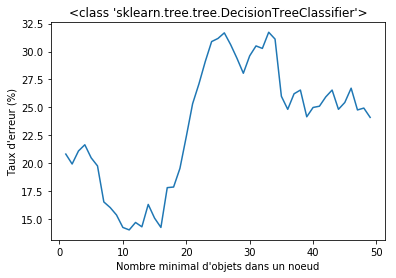

In [58]:
plotErrorLeaf(dffea,classes)

Le nombre d'objets minimal dans un noeud optimal semble être de 10. En dessous, il y a trop de feuiles et il y a sur-apprentissage. Au dessus, le modèle est trop simple.

### Erreur en fonction du nombre de voisins (knn)

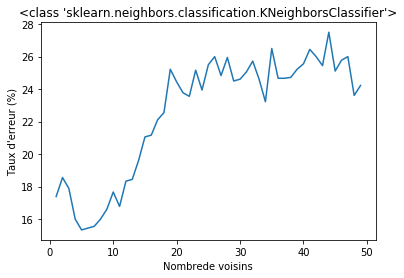

In [59]:
plotErrorNeighbors(dffea,classes)

Si l'algorithme ne considère pas assez de voisins, les résultats sont mauvais car l'apprentissage est trop spécifique (par exemple, s'il y a du bruit un point peut-être classifié comme un voisin proche mais dû au bruit). S'il considère trop de voisins, les classes sont trop générales et donc mal définies.
Le nombre de voisins optimal semble être 10.

## Comparaison des deux méthodes de classification

### Accurracy

Comme l'arbre de décision est une méthode aléatoire on considère un score d'accurracy moyen sur plusieurs runs (cela n'a pas d'effet, peut-être une graine aléatoire perturbe-t-elle le processus).

In [152]:
n=1000
accurracy=np.ndarray(n)
for i in range(n):
    model = DecisionTreeClassifier(criterion = 'entropy', random_state=i, min_samples_leaf=10)
    tr=model.fit(tX_train, ty_train)
    y_predict = model.predict(tX_test)
    accurracy[i]=metrics.balanced_accuracy_score(ty_test, y_predict)
meanAccurracy=np.mean(accurracy)

In [153]:
print u"Accurracy moyenne pondérée pour l'arbre de décision (",n," runs) :", meanAccurracy
print u"Accurracy pondérée des k plus proches voisins :",balanced_accuracy_score(ky_test, ky_predict)

Accurracy moyenne pondérée pour l'arbre de décision ( 1000  runs) : 0.6666666666666665
Accurracy pondérée des k plus proches voisins : 0.6444444444444445


Les scores d'accurracy sont comparables : mais l'algorithme de l'arbre de décision a un meilleur score d'accuracy global.

## Précision et rappel

On considère cette fois des runs uniques de l'arbre de décision.

In [110]:
print "Arbre de décision :\n", metrics.classification_report(ty_test, ty_predict)
print "k plus proches voisins :\n", metrics.classification_report(ky_test, ky_predict)

Arbre de décision :
              precision    recall  f1-score   support

           A       0.00      0.00      0.00         1
           B       0.80      1.00      0.89         4
           C       1.00      1.00      1.00        13

   micro avg       0.94      0.94      0.94        18
   macro avg       0.60      0.67      0.63        18
weighted avg       0.90      0.94      0.92        18

k plus proches voisins :
              precision    recall  f1-score   support

           A       0.00      0.00      0.00         1
           B       0.50      1.00      0.67         2
           C       1.00      0.93      0.97        15

   micro avg       0.89      0.89      0.89        18
   macro avg       0.50      0.64      0.54        18
weighted avg       0.89      0.89      0.88        18



/Users/lisa/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/lisa/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/lisa/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/lisa/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'pre

L'algorithme de l'arbre de décision a des meilleurs scores de précision et rappel pondérés globaux (ligne weighted avg) que les k plus proches voisins. Par conséquent, le f1-score (moyenne harmonique de précision et rappel) est également meilleur. Précisons cependant que cet algorithme est non déterministe et ses résultats peuvent donc varier d'un run à l'autre.


Cependant, il y a toujours le problème de la classe A qui est petite.

### Entropie

On calcule l'entropie pour les deux dernières lignes seulement (classes B et C) car il n'y a pas assez d'éléments dans la classe A.

De même, pour l'arbre de décision, on considère une entropie moyenne sur plusieurs runs (pas d'effet non plus).

In [154]:
n=1000
entrop=np.ndarray((n,2))
for i in range(n):
    model = DecisionTreeClassifier(criterion = 'entropy', random_state=i, min_samples_leaf=10)
    t=model.fit(tX_train, ty_train)
    y_predict = model.predict(tX_test)
    tMP=metrics.confusion_matrix(y_true=ty_test, y_pred=y_predict, labels=sortedLabelList)
    tmdfp = pds.DataFrame(data=tMP, copy=True, index=trueLabels, columns=predictLabels)
    tmdfp = tmdfp.transpose()
    tproba = tmdfp[1:][:].values/tmdfp[1:][:].values.sum(axis=1, keepdims=True) # divide each element of a row by the sum of the row
    tentropy = [stats.entropy(row, base=2) for row in tproba]
    entrop[i]=tentropy
    
meanEntropy=np.sum(entrop,axis=0)/n

In [155]:
print "----------------------------- Arbre de décision -----------------------------"
print "Entropie de chaque (pour ",n," runs) :", meanEntropy
kproba = kmdfp[1:][:].values/kmdfp[1:][:].values.sum(axis=1, keepdims=True) # divide each element of a row by the sum of the row
kentropy = [stats.entropy(row, base=2) for row in kproba]
print "----------------------------- k plus proches voisins -----------------------------"
print "Entropie de chaque classe :", kentropy

----------------------------- Arbre de décision -----------------------------
Entropie de chaque (pour  1000  runs) : [0.72192809 0.        ]
----------------------------- k plus proches voisins -----------------------------
Entropie de chaque classe : [1.5, 0.0]


On a des entropies supérieures à 1, peut-être à cause des NaN dus à la classe A ?

L'entropie mesurée pour les deux classes B et C est plus faible pour l'algorithme de l'arbre de décision (cependant, .

**Conclusion : l'algorithme de l'arbre de décision semble plus performant pour ces données.**